### SNN WP

In [1]:
import snntorch as snn
import snntorch.functional as SF

from snntorch import spikeplot as splt

from snntorch import spikegen

import torch

import torch.nn as nn 
import matplotlib.pyplot as plt
import weight_perturbation as wp

import wandb

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: martin-kraus (brai-lab). Use `wandb login --relogin` to force relogin


True

In [14]:
# layer parameters
num_steps = 100
num_inputs = 1
num_hidden = 30
num_outputs = 1
beta = 0.99
batch_size = 100
# training parameters
loss_hist_wp = []
test_loss_hist_wp = []
loss_hist_bp = []
test_loss_hist_bp = []
epochs = 100
method = "cfd"
sigma = 1e-12
lr = 1e-12
device = "cpu"


config = {
    "learning rate": lr,
    "sigma": sigma,
    "beta": beta,
    "task": "classification",
    "dim_in": num_inputs,
}


""" 
sweep_config = {
    "name": "Regression Sweep",
    "metric": {"goal": "minimize", "name": "test/WP"},
    "entity": "martin-kraus",
    "parameters": {
        "sigma": {"values": [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]},
        "lr": {"values": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]},
        "dim_in": {"values" : 1, 2, 4}
    },
}
"""

' \nsweep_config = {\n    "name": "Regression Sweep",\n    "metric": {"goal": "minimize", "name": "test/WP"},\n    "entity": "martin-kraus",\n    "parameters": {\n        "sigma": {"values": [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]},\n        "lr": {"values": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]},\n        "dim_in": {"values" : 1, 2, 4}\n    },\n}\n'

In [3]:
torch.manual_seed(42)

In [3]:
run = wandb.init(
    project="SNN_WP",
    entity="martin-kraus",
    name=f"regression run with lr: {lr} sigma: {sigma}",
    config=config,
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: martin-kraus. Use `wandb login --relogin` to force relogin


KeyboardInterrupt: 

In [15]:
# define a network


class SNN_WP(nn.Module):
    """
    SNN for weight perturbation. Consists of two fully connected layers of LIFs.
    """
    def __init__(self, beta, num_inputs, num_hidden, num_outputs, loss):
        """
        Initialize the network

        Parameters
        ----------
        beta : float
            The memory leakage of the LIF
        num_inputs : int
            The size of the input layer
        num_hidden : int
            The size of the output layer
        num_outputs : int
            The size of the output
        loss : Loss
            The loss used during training
        """
        super(SNN_WP, self).__init__()

        spike_grad = snn.surrogate.fast_sigmoid(slope=25) #needed for BP
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.loss = loss
        self.num_outputs = num_outputs

    def clean_forward(self, x):
        """Wrapper function of forward for readability purposes"""
        return self.forward(x)

    def noisy_forward(self, x, noise):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains
        noise : dict
            Noise for each network parameter

        Returns
        -------
        spk : Array
            Output spike train
        """
        original_state = self.state_dict()
        params = self.named_parameters()
        trainable_params = {name: p.data for name, p in params if p.requires_grad}
        perturbed_params = wp.dictionary_add(trainable_params, noise)
        self.load_state_dict(perturbed_params, strict=False) 
        out = self.forward(x)

        # reset the parameters back to the unperturbed parameters
        self.load_state_dict(original_state)

        return out

    def forward(self, x):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains

        Returns
        -------
        spk : Array
            Output spike train
        """
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        self.output_potential = torch.zeros((x.shape[0], x.shape[1], self.num_outputs))
        for step in range(x.shape[1]):
            cur1 = self.fc1(x[:, step])  # post-synaptic current <-- spk_in x weight
            spk1, self.mem1 = self.lif1(cur1, self.mem1)  # mem[t+1] <--post-syn current + decayed membrane
            cur2 = self.fc2(spk1)
            spk2, self.mem2 = self.lif2(cur2, self.mem2)

            self.output_potential[:, step] = self.mem2
        return self.output_potential

    def forward_pass(self, x, y, noise=None):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains
        y : Array
            True labels
        noise : dict, optional
            Noise for each network parameter

        Returns
        -------
        loss : long
            The loss of the pass
        """
        if noise is None:
            y_pred = self.clean_forward(x)
            return self.loss(y_pred, y)
        else:
            y_pred = self.noisy_forward(x, noise)
            return self.loss(y_pred, y)

In [5]:
class PeriodicRegressionDataset(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, num_samples, timesteps, dim_in):
        """Linear relation between input and output"""
        self.num_samples = num_samples  # number of generated samples
        feature_lst = []  # store each generated sample in a list

        phases = torch.rand(dim_in)
        amplitudes = torch.rand(dim_in)
        periods = torch.rand(dim_in)
        for idx in range(num_samples):

            for i in range(dim_in):
                start = float(torch.rand(1))
                end = start + float(torch.rand(1)*torch.pi*10)  # random final point
                lin_vec = torch.linspace(
                    start=start, end=end, steps=timesteps
                )  # generate periodic function from 0 to end
                feature = lin_vec.view(timesteps, 1)
                feature_lst.append(feature)  # add sample to list
        self.features = torch.stack(feature_lst, dim=1).view(
            timesteps, num_samples, dim_in
        )  # convert list to tensor

        self.labels = torch.sum(torch.sin(periods*(self.features+phases))*amplitudes, dim=-1).unsqueeze(-1)

        # scale between 0 and 1
        self.labels = self.labels - torch.min(self.labels)
        self.labels = self.labels / torch.max(self.labels)

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        return self.features[:, idx, :], self.labels[:, idx, :]

In [16]:
#
loss = torch.nn.MSELoss()
snn_model = SNN_WP(beta, num_inputs, num_hidden, num_outputs, loss)




In [17]:
dataset = PeriodicRegressionDataset(1000, num_steps, num_inputs)

train_set, test_set = torch.utils.data.random_split(dataset, [900, 100])


train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, drop_last=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=batch_size, drop_last=False
)

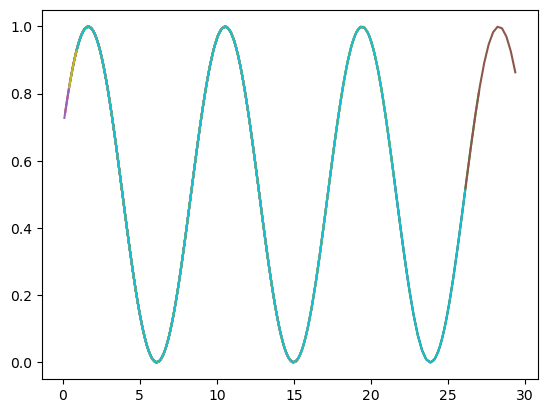

In [18]:
for i in range(10):
    plt.plot(dataset[i][0], dataset[i][1])

In [19]:
def batch_accuracy(test_loader, net):
    with torch.no_grad():
        total = 0
        mse = 0
        net.eval()

        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            mem_rec = net(data)
            mse += torch.mean(torch.square(mem_rec - targets))
            total += mem_rec.size(1)

    return mse / total

In [29]:
@torch.inference_mode()
def training_loop(train_loader, test_loader, model, method):

    sampler = torch.distributions.Normal(0, sigma)
    # make a sampler
    train_loss_hist = []
    test_loss_hist = []

    for e in range(epochs):
        # get input and targets from task
        loss_epoch = []
        for data, targets in iter(train_loader):
            model.train()
            data = data.to(device)
            targets = targets.to(device)

            params = model.named_parameters()
            trainable_params = {name: p.data for name, p in params if p.requires_grad}

            loss = model.forward_pass(data, targets)

            wp_grad = wp.compute_snn_gradient(
                model.forward_pass, data, targets, trainable_params, sampler, method
            )  # do forward passes and compute gradient
            

            """   
            observed_sigma = 0
            num_param = 0
            for val in h.values():
                observed_sigma += torch.sum(val)**2
                print(observed_sigma) 
                num_param += len(val)

            """
            new_weights = wp.update_weights(
                wp_grad, trainable_params, sigma, lr
            )

            model.load_state_dict(
                new_weights, strict=False
            )  # update the weights. Huzzah

            loss_epoch.append(loss.item())

        train_loss_hist.append(torch.mean(torch.tensor(loss_epoch)))
        print(f"Epoch {e}, Train MSE: {train_loss_hist[-1]:.8f}\n")

        with torch.no_grad():
            model.eval()
            # Test set forward pass
            test_mse = batch_accuracy(test_loader, model)
            print(f"Epoch {e}, Test MSE: {test_mse:.8f}\n")
            test_loss_hist.append(test_mse.item())
    return train_loss_hist, test_loss_hist

In [30]:
loss_hist_wp, test_loss_hist_wp = training_loop(
    train_loader, test_loader, snn_model, "cfd"
)

tensor(3.0888e-23)
tensor(3.8040e-23)
tensor(4.2861e-23)
tensor(4.3120e-23)
tensor(8.3169e-24)
tensor(5.1795e-23)
tensor(5.5733e-23)
tensor(5.6915e-23)
tensor(3.8785e-24)
tensor(1.3022e-23)
tensor(1.4262e-23)
tensor(1.4472e-23)
tensor(1.5735e-24)
tensor(2.2701e-24)
tensor(3.1564e-23)
tensor(3.1574e-23)
tensor(1.1176e-22)
tensor(1.9514e-22)
tensor(3.4186e-22)
tensor(3.4195e-22)
tensor(2.6834e-24)
tensor(4.7866e-24)
tensor(1.4887e-23)
tensor(1.5003e-23)
tensor(1.5107e-22)
tensor(2.0975e-22)
tensor(2.0993e-22)
tensor(2.1060e-22)
tensor(3.2965e-23)
tensor(3.3078e-23)
tensor(3.4925e-23)
tensor(3.5100e-23)
tensor(2.7546e-24)
tensor(3.2201e-23)
tensor(1.0654e-22)
tensor(1.0769e-22)
Epoch 0, Train MSE: nan

Epoch 0, Test MSE: nan

tensor(1.9920e-23)
tensor(3.5204e-23)
tensor(4.5921e-23)
tensor(4.6305e-23)
tensor(2.0566e-23)
tensor(3.2176e-23)
tensor(3.3991e-23)
tensor(3.7328e-23)
tensor(6.3764e-24)
tensor(1.6997e-23)
tensor(1.1444e-22)
tensor(1.1449e-22)
tensor(1.6493e-22)
tensor(1.6494e-22)
t

KeyboardInterrupt: 

In [17]:
with torch.no_grad():
    total = 0
    mse = 0
    snn_model.eval()

    test_loader = iter(test_loader)
    for data, targets in test_loader:

        data = data.to(device)[:4]
        targets = targets.to(device)[:4]
        mem_rec = snn_model(data)
        mse += torch.mean(torch.square(mem_rec - targets))
        total += mem_rec.size(1)
# plt.plot(mem_rec.squeeze(), label="membrane")
# plt.plot(targets.squeeze(), label="target")
# plt.legend()
# plt.show()

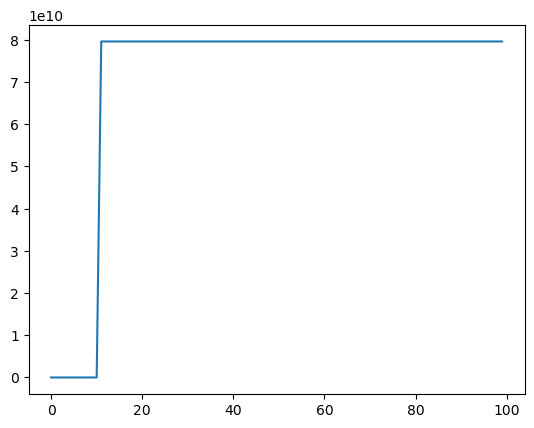

In [18]:
plt.plot(loss_hist_wp)

In [ ]:
# clean network

loss = torch.nn.MSELoss()


SNN = SNN_WP(beta, num_inputs, num_hidden, num_outputs, loss)


train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, drop_last=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=batch_size, drop_last=False
)

In [ ]:
loss_hist_wp_ffd, test_loss_hist_wp_ffd = training_loop(
    train_loader, test_loader, snn_model, "ffd"
)

In [ ]:
# clean network

if sigma == 1:
    loss = torch.nn.MSELoss()

    snn_model = SNN_WP(beta, num_inputs, num_hidden, num_outputs, loss)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=batch_size, drop_last=False
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, batch_size=batch_size, drop_last=False
    )

In [ ]:
# Training loop for BP

if sigma == 1:
    optimizer = torch.optim.SGD(params=snn_model.parameters(), lr=lr)

    for e in range(epochs):

        loss_epoch = []

        for data, targets in iter(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            snn_model.train()

            y_pred = snn_model(data)

            # initialize the loss & sum over time
            loss_val = snn_model.loss(y_pred, targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_epoch.append(loss_val.item())

        loss_hist_bp.append(torch.mean(torch.tensor(loss_epoch)))

        with torch.no_grad():
            # Test set forward pass

            test_mse = batch_accuracy(test_loader, snn_model)
            print(f"Epoch {e}, Test MSE: {test_mse:.2f}\n")
            test_loss_hist_bp.append(test_mse.item())

Epoch 0, Test MSE: 0.00

Epoch 1, Test MSE: 0.00

Epoch 2, Test MSE: 0.00

Epoch 3, Test MSE: 0.00

Epoch 4, Test MSE: 0.00

Epoch 5, Test MSE: 0.00

Epoch 6, Test MSE: 0.00

Epoch 7, Test MSE: 0.00

Epoch 8, Test MSE: 0.00

Epoch 9, Test MSE: 0.00

Epoch 10, Test MSE: 0.00

Epoch 11, Test MSE: 0.00

Epoch 12, Test MSE: 0.00

Epoch 13, Test MSE: 0.00

Epoch 14, Test MSE: 0.00

Epoch 15, Test MSE: 0.00

Epoch 16, Test MSE: 0.00

Epoch 17, Test MSE: 0.00

Epoch 18, Test MSE: 0.00

Epoch 19, Test MSE: 0.00

Epoch 20, Test MSE: 0.00

Epoch 21, Test MSE: 0.00

Epoch 22, Test MSE: 0.00

Epoch 23, Test MSE: 0.00

Epoch 24, Test MSE: 0.00

Epoch 25, Test MSE: 0.00

Epoch 26, Test MSE: 0.00

Epoch 27, Test MSE: 0.00

Epoch 28, Test MSE: 0.00

Epoch 29, Test MSE: 0.00

Epoch 30, Test MSE: 0.00

Epoch 31, Test MSE: 0.00

Epoch 32, Test MSE: 0.00

Epoch 33, Test MSE: 0.00

Epoch 34, Test MSE: 0.00

Epoch 35, Test MSE: 0.00

Epoch 36, Test MSE: 0.00

Epoch 37, Test MSE: 0.00

Epoch 38, Test MSE: 0.

In [ ]:

for e in range(epochs):
    if sigma == 1:
        wandb.log(
            {
                "train_reg/WP_cfd": loss_hist_wp[e],
                "test_reg/WP_cfd": test_loss_hist_wp[e],
                "train_reg/WP_ffd": loss_hist_wp_ffd[e],
                "test_reg/WP_ffd": test_loss_hist_wp_ffd[e],
                "train_reg/BP": loss_hist_bp[e],
                "test_reg/BP": test_loss_hist_bp[e]
            },
            step=e
        )
    else:
        wandb.log(
            {
                "train_reg/WP_cfd": loss_hist_wp[e],
                "test_reg/WP_cfd": test_loss_hist_wp[e],
                "train_reg/WP_ffd": loss_hist_wp_ffd[e],
                "test_reg/WP_ffd": test_loss_hist_wp_ffd[e]
            },
            step=e
        )

In [64]:
wandb.finish()

test/BP,█▆▆▆▆▅▅▅▄▄▄▄▃▄▂▄▄▄▃▄▃▃▃▃▃▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
test/WP,▂▄▃▄▁▅▃▃▃▃▅▅▄▄▄▄▄▄▄▃▄▄▄▃▃▄▄▂▃▄▅▅▄▄▄▆▅▄▇█
train/BP,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/WP,▄▄▄▄▄▂▄▃▄▄▇▅▇▇▅▆▅▄▄▅▆▃▇█▇▆▆▃▃▃▃▃▁▁▁▁▁▁▁▁
test/BP,0.00191
test/WP,0.00287
train/BP,0.18947
train/WP,0.28905
